<a href="https://colab.research.google.com/github/kostique23/Comparison-of-DDPG-and-PPO-Agents/blob/main/Comparison_of_DDPG_and_PPO_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Установка зависимостей

# swig нужен для установки Box2D, а gymnasium[box2d] используется для среды BipedalWalker-v3
!pip install -q swig
!pip install -q gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 30.7 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376422 sha256=db07bbb353249ba231d297f295af152f2b94078bd0042eb57573d6e751cdb3c6
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
#@title Импорт библиотек

import gymnasium as gym  # Gymnasium для работы с симуляцией
import numpy as np  # Для работы с массивами
import torch  # Для работы с тензорами и создания нейросетей
import torch.nn as nn  # Модуль для построения нейросетей
import torch.optim as optim  # Оптимизаторы
from torch.distributions import Normal  # Для обработки распределений в PPO
import matplotlib.pyplot as plt  # Для визуализации
import random  # Для генерации случайных чисел
from collections import deque  # Для хранения буфера опыта

# Определение устройства для вычислений (GPU, если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Реализация DDPG агента

In [ ]:
#@title Буфер опыта

class ReplayBuffer:
    """
    Буфер опыта для хранения переходов (state, action, reward, next_state, done).
    Позволяет агенту семплировать случайные переходы для тренировки.
    """
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)  # Храним фиксированное количество переходов
        self.batch_size = batch_size  # Размер батча для обучения

    def add(self, state, action, reward, next_state, done):
        """
        Добавляет переход в буфер.
        :param state: текущее состояние
        :param action: действие
        :param reward: награда
        :param next_state: следующее состояние
        :param done: флаг завершения эпизода
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        """
        Выбирает случайные переходы из буфера.
        :return: батч из состояний, действий, наград, следующих состояний и флагов завершения
        """
        indices = np.random.choice(len(self.buffer), self.batch_size, replace=False)  # Случайные индексы
        batch = [self.buffer[idx] for idx in indices]  # Извлечение данных по индексам
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def __len__(self):
        return len(self.buffer)  # Возвращает текущий размер буфера

In [ ]:
#@title Актер-Критик сети

class Actor(nn.Module):
    """
    Актёрская сеть для DDPG: предсказывает действия на основе текущего состояния.
    """
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),  # Первый слой
            nn.ReLU(),  # Активация
            nn.Linear(256, 256),  # Второй слой
            nn.ReLU(),  # Активация
            nn.Linear(256, action_dim),  # Выходной слой
            nn.Tanh(),  # Ограничиваем выход в диапазоне [-1, 1]
        )
        self.max_action = max_action  # Максимальное действие для масштабирования

    def forward(self, state):
        """
        Прямой проход через сеть.
        :param state: текущее состояние
        :return: действие в диапазоне [-max_action, max_action]
        """
        return self.max_action * self.network(state)


class Critic(nn.Module):
    """
    Критическая сеть для DDPG: оценивает качество (ценность) пары (состояние, действие).
    """
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),  # Состояние и действие подаются вместе
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),  # Один выход — оценка ценности
        )

    def forward(self, state, action):
        """
        Прямой проход через сеть.
        :param state: текущее состояние
        :param action: текущее действие
        :return: оценка ценности
        """
        return self.network(torch.cat([state, action], dim=1))  # Конкатенация состояния и действия

In [ ]:
#@title Генератор шума для исследования среды

class OUNoise:
    """
    Генератор шума Ornstein-Uhlenbeck: используется для добавления шума к действиям (стратегия исследования).
    """
    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension  # Размерность действия
        self.scale = scale  # Масштаб шума
        self.mu = mu  # Среднее
        self.theta = theta  # Коэффициент скорости возврата к среднему
        self.sigma = sigma  # Стандартное отклонение
        self.state = np.ones(self.action_dimension) * self.mu  # Начальное состояние
        self.reset()

    def reset(self):
        """
        Сбрасывает состояние генератора.
        """
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        """
        Генерирует шум Ornstein-Uhlenbeck.
        :return: шум, добавляемый к действиям
        """
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))  # Случайное движение
        self.state = x + dx
        return self.state * self.scale

In [ ]:
#@title Алгоритм DDPG

class DDPGAgent:
    """
    Агент DDPG: обучается выбирать действия с максимальной ценностью.
    """
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005, lr_actor=1e-4, lr_critic=1e-3):
        # Создаем и копируем веса для актера и критика
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Инициализация буфера опыта и параметров
        self.replay_buffer = ReplayBuffer(buffer_size=1000000, batch_size=100)
        self.max_action = max_action
        self.gamma = gamma  # Коэффициент дисконтирования
        self.tau = tau  # Коэффициент обновления целевых сетей
        self.exploration_noise = OUNoise(action_dim)  # Генератор шума

    def select_action(self, state):
        """
        Выбор действия с добавлением шума для исследования.
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)  # Преобразование состояния в тензор
        action = self.actor(state).cpu().data.numpy().flatten()  # Предсказание действия
        noise = self.exploration_noise.noise()  # Генерация шума
        action = (action + noise).clip(-self.max_action, self.max_action)  # Ограничение действия
        return action

    def train(self):
        """
        Обучение агента DDPG: обновляет сети актора и критика.
        """
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return  # Недостаточно данных для обучения

        # Семплируем данные из буфера опыта
        states, actions, rewards, next_states, dones = self.replay_buffer.sample()
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device).unsqueeze(1)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device).unsqueeze(1)

        # Вычисление целевых значений
        with torch.no_grad():
            next_actions = self.actor_target(next_states)  # Действия по целевой сети
            target_q = self.critic_target(next_states, next_actions)  # Целевая ценность
            target_q = rewards + (1 - dones) * self.gamma * target_q  # Целевая ценность с учетом дисконтирования

        # Обновление критика
        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Обновление актёра
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft-обновление целевых сетей
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

### Реализация PPO агента

In [ ]:
#@title Актер-Критик сеть

class PPOActorCritic(nn.Module):
    """Сеть актера и критика для PPO."""
    def __init__(self, state_dim, action_dim, hidden_dim=64, std=0.0):
        """
        Инициализация сети актера-критика.
        :param state_dim: Размерность входного состояния
        :param action_dim: Размерность пространства действий
        :param hidden_dim: Размер скрытого слоя (по умолчанию 64)
        :param std: Начальное значение стандартного отклонения для распределения действий
        """
        super(PPOActorCritic, self).__init__()

        # Актерская часть сети (предсказывает средние значения действий)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh(),  # Выход ограничен диапазоном [-1, 1]
        )

        # Критическая часть сети (предсказывает значение состояния)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # Выход — скалярное значение состояния
        )

        # Параметр для логарифма стандартного отклонения
        self.log_std = nn.Parameter(torch.ones(1, action_dim) * std)

    def forward(self, state):
        """
        Прямой проход через сеть.
        :param state: Текущее состояние
        :return: Среднее действие (actor) и значение состояния (critic)
        """
        action_mean = self.actor(state)  # Среднее значение действия
        state_value = self.critic(state)  # Значение состояния
        return action_mean, state_value

    def act(self, state):
        """
        Создает распределение действий для заданного состояния.
        :param state: Текущее состояние
        :return: Нормальное распределение действий
        """
        action_mean, _ = self(state)
        std = self.log_std.exp().expand_as(action_mean)  # Преобразуем логарифм std в std
        dist = Normal(action_mean, std)  # Нормальное распределение действий
        return dist

In [ ]:
#@title Алгоритм PPO

class PPOAgent:
    """Агент, реализующий алгоритм PPO."""
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=0.2, lr=3e-4, gae_lambda=0.95, epochs=10, batch_size=64, buffer_size=1000000):
        """
        Инициализация агента PPO.
        :param state_dim: Размерность состояния
        :param action_dim: Размерность действия
        :param gamma: Коэффициент дисконтирования наград
        :param epsilon: Допустимое отклонение в алгоритме PPO (клиппинг)
        :param lr: Скорость обучения
        :param gae_lambda: Параметр GAE (Generalized Advantage Estimation)
        :param epochs: Количество эпох обучения на одном наборе данных
        :param batch_size: Размер мини-пакета для обучения
        :param buffer_size: Максимальный размер буфера для хранения данных
        """
        self.actor_critic = PPOActorCritic(state_dim, action_dim).to(device)  # Создаем сеть актера-критика
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)  # Оптимизатор
        self.gamma = gamma  # Коэффициент дисконтирования
        self.epsilon = epsilon  # Коэффициент клиппинга
        self.gae_lambda = gae_lambda  # Параметр GAE
        self.epochs = epochs  # Количество эпох для обновления
        self.memory = []  # Буфер для хранения переходов
        self.batch_size = batch_size  # Размер мини-пакета
        self.buffer_size = buffer_size  # Максимальный размер буфера

    def select_action(self, state):
        """
        Выбирает действие, основываясь на текущем состоянии.
        :param state: Текущее состояние
        :return: Выбранное действие и логарифм вероятности
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)  # Преобразуем состояние в тензор
        dist = self.actor_critic.act(state)  # Получаем распределение действий
        action = dist.sample()  # Сэмплируем действие из распределения
        log_prob = dist.log_prob(action).sum(axis=-1)  # Логарифм вероятности действия
        return action.cpu().detach().numpy().flatten(), log_prob.cpu().detach()

    def store_transition(self, state, action, reward, next_state, done, log_prob):
        """
        Сохраняет переход в буфер памяти.
        :param state: Текущее состояние
        :param action: Выбранное действие
        :param reward: Полученная награда
        :param next_state: Следующее состояние
        :param done: Флаг завершения эпизода
        :param log_prob: Логарифм вероятности выбранного действия
        """
        self.memory.append((state, action, reward, next_state, done, log_prob))

    def train(self):
        """
        Обучает агента PPO на собранных данных.
        """
        if len(self.memory) < self.batch_size:
            return  # Обучение начнется только после накопления достаточного количества данных

        # Извлекаем данные из памяти
        states, actions, rewards, next_states, dones, old_log_probs = map(np.array, zip(*self.memory))

        # Преобразуем данные в тензоры для PyTorch
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device).unsqueeze(1)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device).unsqueeze(1)
        old_log_probs = torch.FloatTensor(old_log_probs).detach()

        for _ in range(self.epochs):
            returns = []
            advantages = []
            gae = 0
            for i in reversed(range(len(rewards))):
                # Вычисляем значения состояния для текущего и следующего состояний
                _, next_v = self.actor_critic(next_states[i].unsqueeze(0))
                v = self.actor_critic.critic(states[i].unsqueeze(0))

                # Вычисляем TD-ошибку
                if not dones[i]:
                    td_error = rewards[i] + self.gamma * next_v.item() - v.item()
                else:
                    td_error = rewards[i] - v.item()

                # Вычисляем обобщенную оценку преимущества (GAE)
                gae = td_error + self.gamma * self.gae_lambda * gae
                advantages.insert(0, gae)
                returns.insert(0, gae + v.item())  # Возврат — это сумма GAE и значения состояния

            # Преобразуем возвраты и преимущества в тензоры
            returns = torch.tensor(returns, dtype=torch.float32, device=device, requires_grad=True).unsqueeze(1)
            advantages = torch.tensor(advantages, dtype=torch.float32, device=device, requires_grad=True).unsqueeze(1)

            # Нормализуем преимущества
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Обновляем параметры актера
            dist = self.actor_critic.act(states)  # Новое распределение действий
            new_log_probs = dist.log_prob(actions).sum(axis=-1).cpu().detach()  # Новые логарифмы вероятностей
            ratio = torch.exp(new_log_probs - old_log_probs)  # Отношение вероятностей (ratio)
            surr1 = ratio * advantages.cpu()  # Условие обновления 1
            surr2 = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * advantages.cpu()  # Условие обновления 2
            actor_loss = -torch.min(surr1, surr2).mean()  # Функция потерь актера (минимизируем)

            self.optimizer.zero_grad()
            actor_loss.backward()  # Обратное распространение ошибки
            self.optimizer.step()  # Шаг оптимизации

        self.memory = []  # Очищаем память после обучения

### Обучение агентов и сравнение результатов

In [ ]:
#@title Создание агента DDPG

def train_ddpg(agent, env, episodes=1000, max_timesteps=1000):
    rewards_list = []
    average_rewards = []
    best_reward = -float('inf') # Инициализация лучшей награды
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for t in range(max_timesteps):
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            total_reward += reward
            if done:
                break
        rewards_list.append(total_reward)

        # Обновление лучшей награды
        if total_reward > best_reward:
            best_reward = total_reward

        if episode >= 899:
            average_reward = np.mean(rewards_list[899:])
            average_rewards.append(average_reward)
            print(f"Эпизод {episode}, Вознаграждение: {total_reward:.2f}, Среднее вознаграждение: {average_reward:.2f}, Лучшая награда: {best_reward:.2f}")
        else:
            print(f"Эпизод {episode}, Вознаграждение: {total_reward:.2f}, Лучшая награда: {best_reward:.2f}")

    return rewards_list, average_rewards

In [ ]:
#@title Создание агента PPO

def train_ppo(agent, env, episodes=1000, max_timesteps=1000):
    rewards_list = []
    average_rewards = []
    best_reward = -float('inf')

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for t in range(max_timesteps):
            action, log_prob = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done, log_prob)
            state = next_state
            total_reward += reward
            if done:
                break
        agent.train()
        rewards_list.append(total_reward)

        # Обновление лучшей награды
        if total_reward > best_reward:
            best_reward = total_reward
        # Вычисляем среднюю награду за последние 100 эпизодов
        if episode >= 899:  # Начинаем вычислять среднее с 100-го эпизода
            average_reward = np.mean(rewards_list[899:])
            average_rewards.append(average_reward)
            print(f"Эпизод {episode}, Вознаграждение: {total_reward:.2f}, Среднее вознаграждение: {average_reward:.2f}, Лучшая награда: {best_reward:.2f}")
        else:
            print(f"Эпизод {episode}, Вознаграждение: {total_reward:.2f}, Лучшая награда: {best_reward:.2f}")

    return rewards_list, average_rewards

In [ ]:
#@title Создание окружения

env = gym.make('BipedalWalker-v3')

In [ ]:
#@title Обучение DDPG агента

ddpg_agent = DDPGAgent(state_dim=24, action_dim=4, max_action=env.action_space.high[0])
ddpg_rewards = train_ddpg(ddpg_agent, env)

Эпизод 0, Вознаграждение: -92.17, Лучшая награда: -92.17
Эпизод 1, Вознаграждение: -102.04, Лучшая награда: -92.17
Эпизод 2, Вознаграждение: -118.30, Лучшая награда: -92.17
Эпизод 3, Вознаграждение: -118.93, Лучшая награда: -92.17
Эпизод 4, Вознаграждение: -110.57, Лучшая награда: -92.17
Эпизод 5, Вознаграждение: -117.33, Лучшая награда: -92.17
Эпизод 6, Вознаграждение: -118.59, Лучшая награда: -92.17
Эпизод 7, Вознаграждение: -119.31, Лучшая награда: -92.17
Эпизод 8, Вознаграждение: -126.75, Лучшая награда: -92.17
Эпизод 9, Вознаграждение: -161.78, Лучшая награда: -92.17
Эпизод 10, Вознаграждение: -102.92, Лучшая награда: -92.17
Эпизод 11, Вознаграждение: -116.22, Лучшая награда: -92.17
Эпизод 12, Вознаграждение: -105.23, Лучшая награда: -92.17
Эпизод 13, Вознаграждение: -169.47, Лучшая награда: -92.17
Эпизод 14, Вознаграждение: -123.36, Лучшая награда: -92.17
Эпизод 15, Вознаграждение: -114.60, Лучшая награда: -92.17
Эпизод 16, Вознаграждение: -115.18, Лучшая награда: -92.17
Эпизод 1

In [ ]:
#@title Обучение PPO агента

ppo_agent = PPOAgent(state_dim=24, action_dim=4)
ppo_rewards = train_ppo(ppo_agent, env)

Эпизод 0, Вознаграждение: -110.92, Лучшая награда: -110.92
Эпизод 1, Вознаграждение: -120.79, Лучшая награда: -110.92
Эпизод 2, Вознаграждение: -142.98, Лучшая награда: -110.92
Эпизод 3, Вознаграждение: -105.54, Лучшая награда: -105.54
Эпизод 4, Вознаграждение: -111.81, Лучшая награда: -105.54
Эпизод 5, Вознаграждение: -114.93, Лучшая награда: -105.54
Эпизод 6, Вознаграждение: -108.47, Лучшая награда: -105.54
Эпизод 7, Вознаграждение: -101.83, Лучшая награда: -101.83
Эпизод 8, Вознаграждение: -58.10, Лучшая награда: -58.10
Эпизод 9, Вознаграждение: -109.99, Лучшая награда: -58.10
Эпизод 10, Вознаграждение: -110.83, Лучшая награда: -58.10
Эпизод 11, Вознаграждение: -110.88, Лучшая награда: -58.10
Эпизод 12, Вознаграждение: -102.72, Лучшая награда: -58.10
Эпизод 13, Вознаграждение: -70.26, Лучшая награда: -58.10
Эпизод 14, Вознаграждение: -112.53, Лучшая награда: -58.10
Эпизод 15, Вознаграждение: -109.97, Лучшая награда: -58.10
Эпизод 16, Вознаграждение: -104.89, Лучшая награда: -58.10
Э

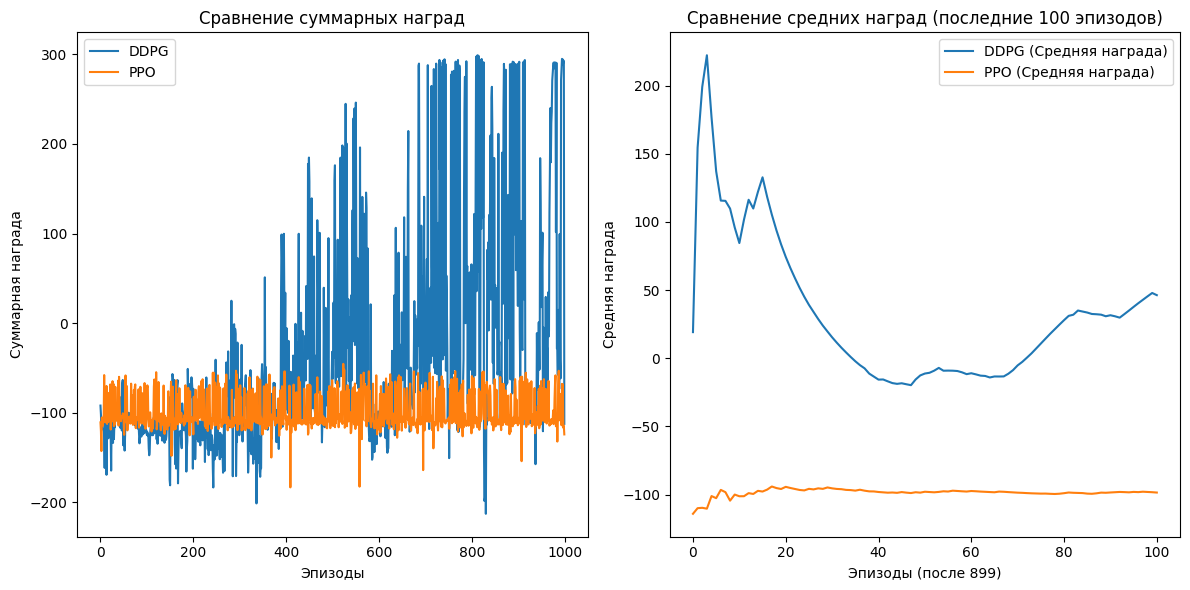

In [ ]:
#@title Визуализация результатов
import matplotlib.pyplot as plt

# Построение графиков
def plot_rewards(ddpg_rewards, ppo_rewards, average_ddpg_rewards, average_ppo_rewards):
    episodes_ddpg = list(range(len(ddpg_rewards)))
    episodes_ppo = list(range(len(ppo_rewards)))

    # График суммарной награды
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episodes_ddpg, ddpg_rewards, label="DDPG")
    plt.plot(episodes_ppo, ppo_rewards, label="PPO")
    plt.xlabel("Эпизоды")
    plt.ylabel("Суммарная награда")
    plt.title("Сравнение суммарных наград")
    plt.legend()

    # График средней награды за последние 100 эпизодов
    plt.subplot(1, 2, 2)
    plt.plot(range(len(average_ddpg_rewards)), average_ddpg_rewards, label="DDPG (Средняя награда)")
    plt.plot(range(len(average_ppo_rewards)), average_ppo_rewards, label="PPO (Средняя награда)")
    plt.xlabel("Эпизоды (после 899)")
    plt.ylabel("Средняя награда")
    plt.title("Сравнение средних наград (последние 100 эпизодов)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Вызов функции для построения графиков
plot_rewards(ddpg_rewards[0], ppo_rewards[0], ddpg_rewards[1], ppo_rewards[1])

### Результаты обучения DDPG и PPO

Результаты обучения DDPG и PPO на среде BipedalWalker-v3 показывают явное преимущество DDPG.

**Анализ графиков**

 * График суммарных наград: DDPG демонстрирует значительно более высокий уровень суммарной награды, начиная примерно с 300 эпизода. PPO же большую часть времени остается на уровне около -100, показывая незначительный прогресс.

 * График средних наград (последние 100 эпизодов): Этот график подтверждает наблюдения с первого графика. DDPG достигает значительно более высоких средних наград (около 50) в последние 100 эпизодов, в то время как PPO колеблется около -100.

**Выводы**

DDPG значительно превзошел PPO в этой задаче. Он смог научиться более эффективной стратегии управления роботом, достигая гораздо больших наград и демонстрируя более стабильное обучение. PPO, напротив, не смог эффективно исследовать пространство состояний и действий и застрял в локальном минимуме.

**Рекомендации по улучшению моделей**

 * Общие рекомендации:

  * Тюнинг гиперпараметров
  
  Можно провести более тщательный подбор гиперпараметров для обоих алгоритмов.
  
  Для DDPG это могут быть скорости обучения актера и критика, коэффициенты tau и gamma, параметры шума Ornstein-Uhlenbeck.
  
  Для PPO — epsilon, gae_lambda, скорость обучения, размер батча. Можно использовать автоматизированные методы тюнинга, например, optuna или hyperopt.

  * Нормализация данных
  
  Нормализация входных состояний (например, вычитание среднего и деление на стандартное отклонение) может ускорить и стабилизировать обучение обоих алгоритмов.

  * Различные архитектуры сетей
  
  Можно поэкспериментировать с разными архитектурами сетей актера и критика. Более глубокие или широкие сети могут улучшить способность агента представлять сложные зависимости в среде.

  * Другие функции активации
  
  Можно попробовать другие функции активации, помимо ReLU (например, LeakyReLU, ELU, SELU).


* Рекомендации для PPO:

  * Изменение epsilon
  
  Можно попробовать уменьшить значение epsilon. Слишком большое значение может ограничивать способность агента к обучению на больших обновлениях политики.

  * Изменение gae_lambda
  
  Можно поэкспериментировать с разными значениями gae_lambda. Этот параметр контролирует, насколько сильно агент учитывает будущие награды при оценке преимущества.

  * Более частые обновления политики
  
  Можно попробовать увеличить количество эпох обучения или уменьшить размер батча. Это может привести к более частым обновлениям политики и более быстрому обучению.


* Рекомендации для DDPG:

  * Разные стратегии исследования
  
  Помимо шума, можно использовать другие стратегии исследования, такие как добавление гауссовского шума или epsilon-greedy.

  * Приоритетный буфер опыта
  
  Этот метод позволяет агенту чаще обучаться на более важных переходах, что может ускорить обучение.
